# Time Series Prediction with RNN

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
print(tf.__version__)

2.0.0-rc1


In [2]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)

1 Physical GPUs, 1 Logical GPUs


## Creating dataset

In [3]:
def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)

def trend(time, slope=0):
    return slope * time

def seasonal_pattern(season_time):
    """Just an arbitrary pattern, you can change it if you wish"""
    return np.where(season_time < 0.4,
                    np.cos(season_time * 2 * np.pi),
                    1 / np.exp(3 * season_time))

def seasonality(time, period, amplitude=1, phase=0):
    """Repeats the same pattern at each period"""
    season_time = ((time + phase) % period) / period
    return amplitude * seasonal_pattern(season_time)

def noise(time, noise_level=1, seed=None):
    rnd = np.random.RandomState(seed)
    return rnd.randn(len(time)) * noise_level

time = np.arange(4 * 365 + 1, dtype="float32")
baseline = 10
series = trend(time, 0.1)  
baseline = 10
amplitude = 40
slope = 0.05
noise_level = 5

# Create the series
series = baseline + trend(time, slope) + seasonality(time, period=365, amplitude=amplitude)
# Update with noise
series += noise(time, noise_level, seed=42)

split_time = 1000
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

window_size = 20
batch_size = 32
shuffle_buffer_size = 1000

In [4]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    dataset = tf.data.Dataset.from_tensor_slices(series)
    dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
    dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))
    dataset = dataset.shuffle(shuffle_buffer).map(lambda window: (window[:-1], window[-1]))
    dataset = dataset.batch(batch_size).prefetch(1)
    return dataset

## Training with dynamic learning rate

Huber loss: [Huber loss function](https://www.wikizeroo.org/index.php?q=aHR0cHM6Ly9lbi53aWtpcGVkaWEub3JnL3dpa2kvSHViZXJfbG9zcw)

In [5]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)

train_set = windowed_dataset(x_train, window_size, batch_size=128, shuffle_buffer=shuffle_buffer_size)

model = tf.keras.models.Sequential([
  tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1),
                      input_shape=[None]),
  tf.keras.layers.SimpleRNN(40, return_sequences=True),
  tf.keras.layers.SimpleRNN(40),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 100.0)
])

lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 20))
optimizer = tf.keras.optimizers.SGD(lr=1e-8, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
with tf.device('/device:GPU:0'):
    history = model.fit(train_set, epochs=100, callbacks=[lr_schedule])

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Epoch 1/100
8/8 [==============================] - 2s 231ms/step - loss: 195.6164 - mae: 196.0720
Epoch 2/100
8/8 [==============================] - 0s 30ms/step - loss: 194.5325 - mae: 195.2834
Epoch 3/100
8/8 [==============================] - 0s 30ms/step - loss: 192.9727 - mae: 194.0106
Epoch 4/100
8/8 [==============================] - 0s 27ms/step - loss: 192.1908 - mae: 192.4087
Epoch 5/100
8/8 [==============================] - 0s 28ms/step - loss: 190.2552 - mae: 190.5219
Epoch 6/100
8/8 [==============================] - 0s 31ms/step - loss: 187.3451 - mae: 188.3526
Epoch 7/100
8/8 [==============================] - 0s 30ms/step - loss: 185.5730 - mae: 185.8774
Epoch 8/100
8/8 [==============================] - 0s 26ms/step - loss: 182.9678 - mae: 183.0458
Epoch 9/100
8/8 [==============================] - 0s 28ms/step - loss: 179.8839 - mae: 179.8092
Epoch 10/100
8/8 [==============

Epoch 61/100
8/8 [==============================] - 0s 29ms/step - loss: 6.6454 - mae: 7.2942
Epoch 62/100
8/8 [==============================] - 0s 29ms/step - loss: 7.9853 - mae: 8.6790
Epoch 63/100
8/8 [==============================] - 0s 29ms/step - loss: 7.4442 - mae: 8.0097
Epoch 64/100
8/8 [==============================] - 0s 27ms/step - loss: 7.5553 - mae: 8.0209
Epoch 65/100
8/8 [==============================] - 0s 29ms/step - loss: 6.7088 - mae: 7.1988
Epoch 66/100
8/8 [==============================] - 0s 28ms/step - loss: 8.0437 - mae: 8.3895
Epoch 67/100
8/8 [==============================] - 0s 28ms/step - loss: 6.5546 - mae: 7.0532
Epoch 68/100
8/8 [==============================] - 0s 28ms/step - loss: 6.0369 - mae: 6.5036
Epoch 69/100
8/8 [==============================] - 0s 32ms/step - loss: 8.2954 - mae: 9.2430
Epoch 70/100
8/8 [==============================] - 0s 37ms/step - loss: 8.5279 - mae: 8.7814
Epoch 71/100
8/8 [==============================] - 0s 34ms/

## Result

- We can find correct learning rate for our model.

[1e-08, 0.0001, 0, 30]

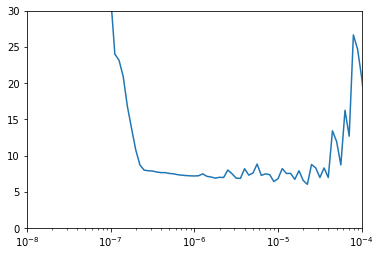

In [6]:
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-8, 1e-4, 0, 30])

## Training with fixed learning rate

In [7]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)

dataset = windowed_dataset(x_train, window_size, batch_size=128, shuffle_buffer=shuffle_buffer_size)

model = tf.keras.models.Sequential([
  tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1),
                      input_shape=[None]),
  tf.keras.layers.SimpleRNN(40, return_sequences=True),
  tf.keras.layers.SimpleRNN(40),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 100.0)
])

optimizer = tf.keras.optimizers.SGD(lr=5e-5, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])

with tf.device('/device:GPU:0'):
    history = model.fit(dataset,epochs=400)

Epoch 1/400
8/8 [==============================] - 2s 248ms/step - loss: 80.8704 - mae: 83.5782
Epoch 2/400
8/8 [==============================] - 0s 34ms/step - loss: 24.4966 - mae: 24.3853
Epoch 3/400
8/8 [==============================] - 0s 40ms/step - loss: 18.2013 - mae: 18.7074
Epoch 4/400
8/8 [==============================] - 0s 41ms/step - loss: 14.2669 - mae: 14.6785
Epoch 5/400
8/8 [==============================] - 0s 33ms/step - loss: 10.8969 - mae: 11.2667
Epoch 6/400
8/8 [==============================] - 0s 29ms/step - loss: 11.3652 - mae: 12.5687
Epoch 7/400
8/8 [==============================] - 0s 28ms/step - loss: 12.7136 - mae: 13.0879
Epoch 8/400
8/8 [==============================] - 0s 28ms/step - loss: 12.2051 - mae: 12.4872
Epoch 9/400
8/8 [==============================] - 0s 30ms/step - loss: 15.1404 - mae: 15.1925
Epoch 10/400
8/8 [==============================] - 0s 30ms/step - loss: 21.4325 - mae: 21.9100
Epoch 11/400
8/8 [==============================

8/8 [==============================] - 0s 32ms/step - loss: 7.6750 - mae: 8.0478
Epoch 66/400
8/8 [==============================] - 0s 32ms/step - loss: 10.6264 - mae: 10.7636
Epoch 67/400
8/8 [==============================] - 0s 33ms/step - loss: 7.7561 - mae: 8.0844
Epoch 68/400
8/8 [==============================] - 0s 32ms/step - loss: 7.5457 - mae: 7.8403
Epoch 69/400
8/8 [==============================] - 0s 32ms/step - loss: 8.8670 - mae: 9.5816
Epoch 70/400
8/8 [==============================] - 0s 32ms/step - loss: 7.4799 - mae: 7.8952
Epoch 71/400
8/8 [==============================] - 0s 26ms/step - loss: 5.6059 - mae: 6.0658
Epoch 72/400
8/8 [==============================] - 0s 28ms/step - loss: 5.8072 - mae: 6.1936
Epoch 73/400
8/8 [==============================] - 0s 28ms/step - loss: 5.1843 - mae: 5.6525
Epoch 74/400
8/8 [==============================] - 0s 28ms/step - loss: 5.4651 - mae: 5.9366
Epoch 75/400
8/8 [==============================] - 0s 30ms/step - loss

8/8 [==============================] - 0s 43ms/step - loss: 4.5244 - mae: 5.0197
Epoch 238/400
8/8 [==============================] - 0s 44ms/step - loss: 5.4780 - mae: 5.8236
Epoch 239/400
8/8 [==============================] - 0s 43ms/step - loss: 4.3766 - mae: 4.8842
Epoch 240/400
8/8 [==============================] - 0s 42ms/step - loss: 5.2774 - mae: 5.6963
Epoch 241/400
8/8 [==============================] - 0s 42ms/step - loss: 4.6291 - mae: 5.0662
Epoch 242/400
8/8 [==============================] - 0s 46ms/step - loss: 4.4160 - mae: 4.8460
Epoch 243/400
8/8 [==============================] - 0s 55ms/step - loss: 4.4479 - mae: 4.9451
Epoch 244/400
8/8 [==============================] - 0s 42ms/step - loss: 6.0198 - mae: 6.8429
Epoch 245/400
8/8 [==============================] - 0s 40ms/step - loss: 8.3112 - mae: 8.8201
Epoch 246/400
8/8 [==============================] - 0s 36ms/step - loss: 6.0980 - mae: 6.5278
Epoch 247/400
8/8 [==============================] - 0s 37ms/ste

## Results

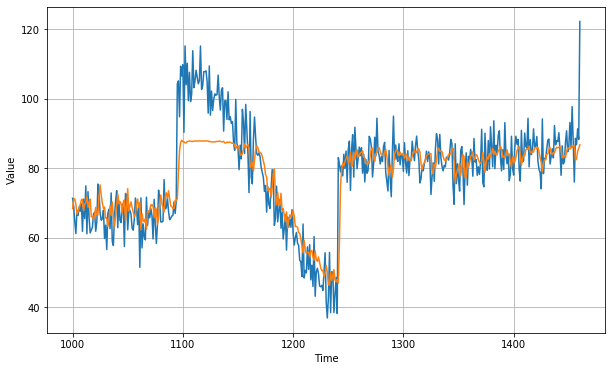

In [8]:
forecast=[]
for time in range(len(series) - window_size):
    forecast.append(model.predict(series[time:time + window_size][np.newaxis]))

forecast = forecast[split_time-window_size:]
results = np.array(forecast)[:, 0, 0]


plt.figure(figsize=(10, 6))

plot_series(time_valid, x_valid)
plot_series(time_valid, results)

In [9]:
tf.keras.metrics.mean_absolute_error(x_valid, results).numpy()

6.009353

<Figure size 432x288 with 0 Axes>

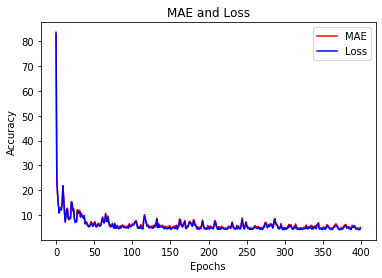

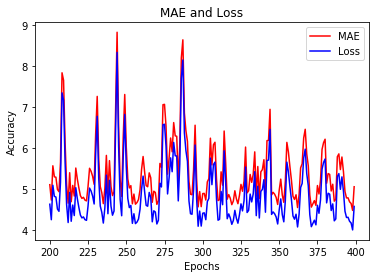

<Figure size 432x288 with 0 Axes>

In [10]:
import matplotlib.image  as mpimg
import matplotlib.pyplot as plt

#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
mae=history.history['mae']
loss=history.history['loss']

epochs=range(len(loss)) # Get number of epochs

#------------------------------------------------
# Plot MAE and Loss
#------------------------------------------------
plt.plot(epochs, mae, 'r')
plt.plot(epochs, loss, 'b')
plt.title('MAE and Loss')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(["MAE", "Loss"])

plt.figure()

epochs_zoom = epochs[200:]
mae_zoom = mae[200:]
loss_zoom = loss[200:]

#------------------------------------------------
# Plot Zoomed MAE and Loss
#------------------------------------------------
plt.plot(epochs_zoom, mae_zoom, 'r')
plt.plot(epochs_zoom, loss_zoom, 'b')
plt.title('MAE and Loss')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(["MAE", "Loss"])

plt.figure()